# IoT - Human Detection Notebook 📹

Giovanni Baccichet (`10851745`) - Politecnico di Milano

## Libraries 📔

In [96]:
import pandas as pd 
import glob
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import seaborn as sns
from datetime import datetime
import time
import os

In [97]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

import pickle

## Importing Data Frame 📁

Setting working directory.

In [98]:
working_directory = os.getcwd()
path = working_directory + '/Dataset/'

In [99]:
df = pd.read_csv('Dataset/mini_dataset.csv', encoding = "utf-8", index_col=False, on_bad_lines='skip')

df.columns=["Time", "Source", "Destination", "Protocol", "Port", "Length"]

Converting `Time` column from `object` type to `datetime`.

In [100]:
df['Time'] = pd.to_datetime(df['Time'])

Adding `Direction` column to better visualize the traffic behavior.

In [101]:
df['Direction'] = np.where(df['Source']== '192.168.178.69', 'Outbound', 'Inbound')

df.drop('Port',axis = 1,inplace= True)

In [102]:
df.head()

,Time,Source,Destination,Protocol,Length,Direction
0,2022-01-01 00:45:40.067370,149.137.10.51,192.168.178.69,17,115,Inbound
1,2022-01-01 00:45:40.070269,149.137.10.51,192.168.178.69,17,1130,Inbound
2,2022-01-01 00:45:40.070459,149.137.10.51,192.168.178.69,17,1129,Inbound
3,2022-01-01 00:45:40.070462,149.137.10.51,192.168.178.69,17,1129,Inbound
4,2022-01-01 00:45:40.070603,149.137.10.51,192.168.178.69,17,1129,Inbound


## Time related stuff ⏱

Preparing the acquired ground truth: timestamps need to be converted properly in order to be comparable with the data frame's ones.

In [103]:
present = datetime.fromtimestamp(1656456342311/1000).time()
end_present = datetime.fromtimestamp(1656456514003/1000).time()
end = datetime.fromtimestamp(1656456663938/1000).time()

print("Beginning of the acquisition process: ", present)
print("Person exists the frame: ", end_present)
print("End of the acquisition process: ", end)

Beginning of the acquisition process:  00:45:42.311000
Person exists the frame:  00:48:34.003000
End of the acquisition process:  00:51:03.938000


Adding the ground truth to the data frame, based on previously acquired timestamps.

In [104]:
df['Time'] = pd.to_datetime(df['Time'])

result = df.loc[df['Time'].dt.time.between(present, end_present), 'Person'] = 1

result = df.loc[df['Time'].dt.time.between(end_present, end), 'Person'] = 0

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52447 entries, 0 to 52446
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         52447 non-null  datetime64[ns]
 1   Source       52447 non-null  object        
 2   Destination  52447 non-null  object        
 3   Protocol     52447 non-null  int64         
 4   Length       52447 non-null  int64         
 5   Direction    52447 non-null  object        
 6   Person       41653 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.8+ MB


In [106]:
# df.drop('Port',axis = 1,inplace= True)
df.dropna(subset = ["Person"], inplace=True)

df.head(100)

,Time,Source,Destination,Protocol,Length,Direction,Person
365,2022-01-01 00:45:42.353010,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
366,2022-01-01 00:45:42.452673,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
367,2022-01-01 00:45:42.552815,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
368,2022-01-01 00:45:42.567421,149.137.10.51,192.168.178.69,17,115,Inbound,1.0
369,2022-01-01 00:45:42.612744,192.168.178.69,149.137.10.51,17,106,Outbound,1.0
...,...,...,...,...,...,...,...
460,2022-01-01 00:45:43.052726,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
461,2022-01-01 00:45:43.152659,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
462,2022-01-01 00:45:43.199824,149.137.10.51,192.168.178.69,17,106,Inbound,1.0
463,2022-01-01 00:45:43.200339,149.137.10.51,192.168.178.69,17,130,Inbound,1.0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41653 entries, 365 to 42017
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time         41653 non-null  datetime64[ns]
 1   Source       41653 non-null  object        
 2   Destination  41653 non-null  object        
 3   Protocol     41653 non-null  int64         
 4   Length       41653 non-null  int64         
 5   Direction    41653 non-null  object        
 6   Person       41653 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.5+ MB


### Re-sampling Data Frame ✂️

In [108]:
df = df.set_index('Time')
df

,Source,Destination,Protocol,Length,Direction,Person
Time,,,,,,
2022-01-01 00:45:42.353010,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
2022-01-01 00:45:42.452673,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
2022-01-01 00:45:42.552815,192.168.178.69,149.137.10.51,17,130,Outbound,1.0
2022-01-01 00:45:42.567421,149.137.10.51,192.168.178.69,17,115,Inbound,1.0
2022-01-01 00:45:42.612744,192.168.178.69,149.137.10.51,17,106,Outbound,1.0
...,...,...,...,...,...,...
2022-01-01 00:51:03.738642,149.137.10.51,192.168.178.69,17,1017,Inbound,0.0
2022-01-01 00:51:03.748763,149.137.10.51,192.168.178.69,17,1017,Inbound,0.0
2022-01-01 00:51:03.756863,192.168.178.69,149.137.10.51,17,130,Outbound,0.0


In [109]:
FREQ = '450ms'

df_resampled = df.groupby(pd.Grouper(freq=FREQ)).first()

In [110]:
df_resampled['PacketNumber'] = df.groupby(pd.Grouper(freq=FREQ))['Source'].count()

df_resampled['PacketIntervalAvg'] = 450/df_resampled['PacketNumber']

df_resampled['PacketSizeAvg'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].mean()

df_resampled['PacketSizeStd'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].std()

df_resampled['PacketSizeMed'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].median()

df_resampled['PacketSizeMin'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].min()

df_resampled['PacketSizeMax'] = df.groupby(pd.Grouper(freq=FREQ))['Length'].max()

df_resampled['InboundCount'] = df.groupby(pd.Grouper(freq=FREQ))['Direction'].apply(lambda x: (x=='Inbound').sum())

df_resampled['OutboundCount'] = df.groupby(pd.Grouper(freq=FREQ))['Direction'].apply(lambda x: (x=='Outbound').sum())

df_resampled['InOutBoundRate'] = df_resampled['InboundCount']/df_resampled['OutboundCount']

In [111]:
df_resampled.drop('Source',axis = 1,inplace= True)

df_resampled.drop('Destination',axis = 1,inplace= True)

df_resampled.drop('Protocol',axis = 1,inplace= True)

df_resampled.drop('Length',axis = 1,inplace= True)

df_resampled.drop('Direction',axis = 1,inplace= True)



In [112]:
df_resampled

,Person,PacketNumber,PacketIntervalAvg,PacketSizeAvg,PacketSizeStd,PacketSizeMed,PacketSizeMin,PacketSizeMax,InboundCount,OutboundCount,InOutBoundRate
Time,,,,,,,,,,,
2022-01-01 00:45:42.300,1.0,38,11.842105,743.289474,534.355328,1086.0,106,1275,30,8,3.750000
2022-01-01 00:45:42.750,1.0,60,7.500000,864.833333,451.467219,1048.0,106,1284,51,9,5.666667
2022-01-01 00:45:43.200,1.0,78,5.769231,989.243590,396.624104,1165.5,106,1302,72,6,12.000000
2022-01-01 00:45:43.650,1.0,117,3.846154,970.743590,391.461302,1124.0,94,1313,110,7,15.714286
2022-01-01 00:45:44.100,1.0,37,12.162162,962.108108,449.186288,1180.0,115,1310,32,5,6.400000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 00:51:01.800,0.0,83,5.421687,583.024096,446.273841,513.0,106,1303,78,5,15.600000
2022-01-01 00:51:02.250,0.0,81,5.555556,999.567901,438.284523,1225.0,106,1313,74,7,10.571429
2022-01-01 00:51:02.700,0.0,78,5.769231,1009.397436,362.278408,1152.0,106,1266,73,5,14.600000


In [113]:
df_resampled = df_resampled.dropna()
df_resampled

,Person,PacketNumber,PacketIntervalAvg,PacketSizeAvg,PacketSizeStd,PacketSizeMed,PacketSizeMin,PacketSizeMax,InboundCount,OutboundCount,InOutBoundRate
Time,,,,,,,,,,,
2022-01-01 00:45:42.300,1.0,38,11.842105,743.289474,534.355328,1086.0,106,1275,30,8,3.750000
2022-01-01 00:45:42.750,1.0,60,7.500000,864.833333,451.467219,1048.0,106,1284,51,9,5.666667
2022-01-01 00:45:43.200,1.0,78,5.769231,989.243590,396.624104,1165.5,106,1302,72,6,12.000000
2022-01-01 00:45:43.650,1.0,117,3.846154,970.743590,391.461302,1124.0,94,1313,110,7,15.714286
2022-01-01 00:45:44.100,1.0,37,12.162162,962.108108,449.186288,1180.0,115,1310,32,5,6.400000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 00:51:01.800,0.0,83,5.421687,583.024096,446.273841,513.0,106,1303,78,5,15.600000
2022-01-01 00:51:02.250,0.0,81,5.555556,999.567901,438.284523,1225.0,106,1313,74,7,10.571429
2022-01-01 00:51:02.700,0.0,78,5.769231,1009.397436,362.278408,1152.0,106,1266,73,5,14.600000


## Data Frame Normalization

In [114]:
df_resampled.info()

# Replacing Inf values with NaN
df_resampled = df_resampled.replace([np.inf, -np.inf], np.nan)

# Dropping all occurrences of NaN
df_resampled = df_resampled.dropna()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 715 entries, 2022-01-01 00:45:42.300000 to 2022-01-01 00:51:03.600000
Freq: 450L
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Person             715 non-null    float64
 1   PacketNumber       715 non-null    int64  
 2   PacketIntervalAvg  715 non-null    float64
 3   PacketSizeAvg      715 non-null    float64
 4   PacketSizeStd      715 non-null    float64
 5   PacketSizeMed      715 non-null    float64
 6   PacketSizeMin      715 non-null    int64  
 7   PacketSizeMax      715 non-null    int64  
 8   InboundCount       715 non-null    int64  
 9   OutboundCount      715 non-null    int64  
 10  InOutBoundRate     715 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 67.0 KB


In [116]:
X = df_resampled.drop('Person', axis=1)
Y = df_resampled['Person']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
x_test, x_validate, y_test, y_validate = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [117]:
# Normalize
min_max_scaler = MinMaxScaler().fit(x_train)

# Apply normalization to dataset
x_train = min_max_scaler.transform(x_train)
x_validate = min_max_scaler.transform(x_validate)
x_test = min_max_scaler.transform(x_test)

# All values between 0 and 1
pd.Series(x_train.flatten()).describe()

count    4290.000000
mean        0.485635
std         0.290847
min         0.000000
25%         0.257484
50%         0.435024
75%         0.709091
max         1.000000
dtype: float64

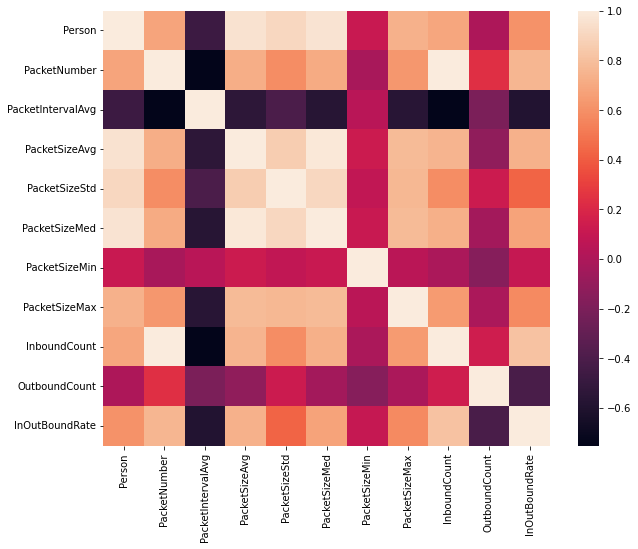

In [118]:
corr = df_resampled.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr)
plt.show()

## KNN

In [119]:
classifier = KNeighborsClassifier(n_neighbors=100)
classifier.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [120]:
y_pred = classifier.predict(x_test)

In [121]:
precision, recall, fscore, support = score(y_test, y_pred)
d = {'Precision': precision, 'Recall' : recall, 'FScore': fscore}
results = pd.DataFrame(data=d)
results

,Precision,Recall,FScore
0,1.0000,0.954545,0.976744
1,0.9625,1.000000,0.980892


In [122]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[63  3]
 [ 0 77]]
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        66
         1.0       0.96      1.00      0.98        77

    accuracy                           0.98       143
   macro avg       0.98      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

